In [2]:
from scipy.ndimage import measurements,morphology
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [5]:
from tensorflow.compat.v1 import keras
import tensorflow as tf

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

Обучение модели распознавания отдельных символов

In [17]:
x = np.load('/content/drive/MyDrive/ColabFiles/Text_Recognition/save64_X_D.npy')
y = np.load('/content/drive/MyDrive/ColabFiles/Text_Recognition/save64_Y_D.npy')

In [18]:
print(x.shape,y.shape)

(56672, 64, 64) (56672,)


In [19]:
Y_train = to_categorical(pd.Series(y).astype('category').cat.codes, num_classes = 71)
Y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
letDict = pd.Series(y).unique()
catDict = pd.Series(y).astype('category').cat.codes.unique()
dic = {}

for i in range(len(catDict)):
  dic[str(catDict[i])] = letDict[i] 

In [22]:
y = np.load('/content/drive/MyDrive/ColabFiles/Text_Recognition/save64_Y_D.npy')
letDict = pd.Series(y).unique()
catDict = pd.Series(y).astype('category').cat.codes.unique()
dic = {}
revDic = {}
for i in range(len(catDict)):
  dic[str(catDict[i])] = letDict[i] 
  revDic[letDict[i]] = str(catDict[i])
print(dic)
print(revDic)

{'0': 'а', '1': 'б', '2': 'в', '3': 'г', '4': 'д', '5': 'е', '6': 'ж', '7': 'з', '8': 'и', '9': 'й', '10': 'к', '11': 'л', '12': 'м', '13': 'н', '14': 'о', '15': 'п', '16': 'р', '17': 'с', '18': 'т', '19': 'у', '20': 'ф', '21': 'х', '22': 'ц', '23': 'ч', '24': 'ш', '25': 'щ', '26': 'ъ', '27': 'ы', '28': 'ь', '29': 'э', '30': 'ю', '31': 'я'}
{'а': '0', 'б': '1', 'в': '2', 'г': '3', 'д': '4', 'е': '5', 'ж': '6', 'з': '7', 'и': '8', 'й': '9', 'к': '10', 'л': '11', 'м': '12', 'н': '13', 'о': '14', 'п': '15', 'р': '16', 'с': '17', 'т': '18', 'у': '19', 'ф': '20', 'х': '21', 'ц': '22', 'ч': '23', 'ш': '24', 'щ': '25', 'ъ': '26', 'ы': '27', 'ь': '28', 'э': '29', 'ю': '30', 'я': '31'}


In [23]:
Y_train.shape

(56672, 71)

In [24]:
train_X = x.astype(int)
train_X = ((train_X*255)-127.5)/127.5
train_X = np.expand_dims(train_X,-1)

In [25]:
train_X.shape

(56672, 64, 64, 1)

In [26]:
s=np.arange(train_X.shape[0])
np.random.seed(666)
np.random.shuffle(s)
train_X=train_X[s]
Y_train=Y_train[s]

In [27]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.20))


model.add(Flatten())
model.add(Dense(400, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(71, activation = "softmax"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In [29]:
import tensorflow as tf
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [30]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
history = model.fit(train_X, Y_train, batch_size = 86, epochs = 4)

Epoch 1/4
659/659 [==============================] - 54s 83ms/step - loss: 0.4505 - accuracy: 0.8676
Epoch 2/4
659/659 [==============================] - 53s 81ms/step - loss: 0.2442 - accuracy: 0.9266
Epoch 3/4
659/659 [==============================] - 53s 81ms/step - loss: 0.1906 - accuracy: 0.9431
Epoch 4/4
659/659 [==============================] - 53s 81ms/step - loss: 0.1642 - accuracy: 0.9489


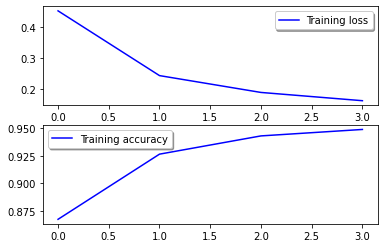

In [34]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
model.save('/content/drive/MyDrive/ColabFiles/Text_Recognition/signRecog_101900_model_D.h5')

Пробное распознование символа


In [35]:
model = keras.models.load_model('/content/drive/MyDrive/ColabFiles/Text_Recognition/signRecog_101900_model_D.h5')

In [37]:
img = cv2.imread("/content/drive/MyDrive/ColabFiles/Text_Recognition/HelloWorld.jpg")
coords = get_LettersCoord(img,False)[7]
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

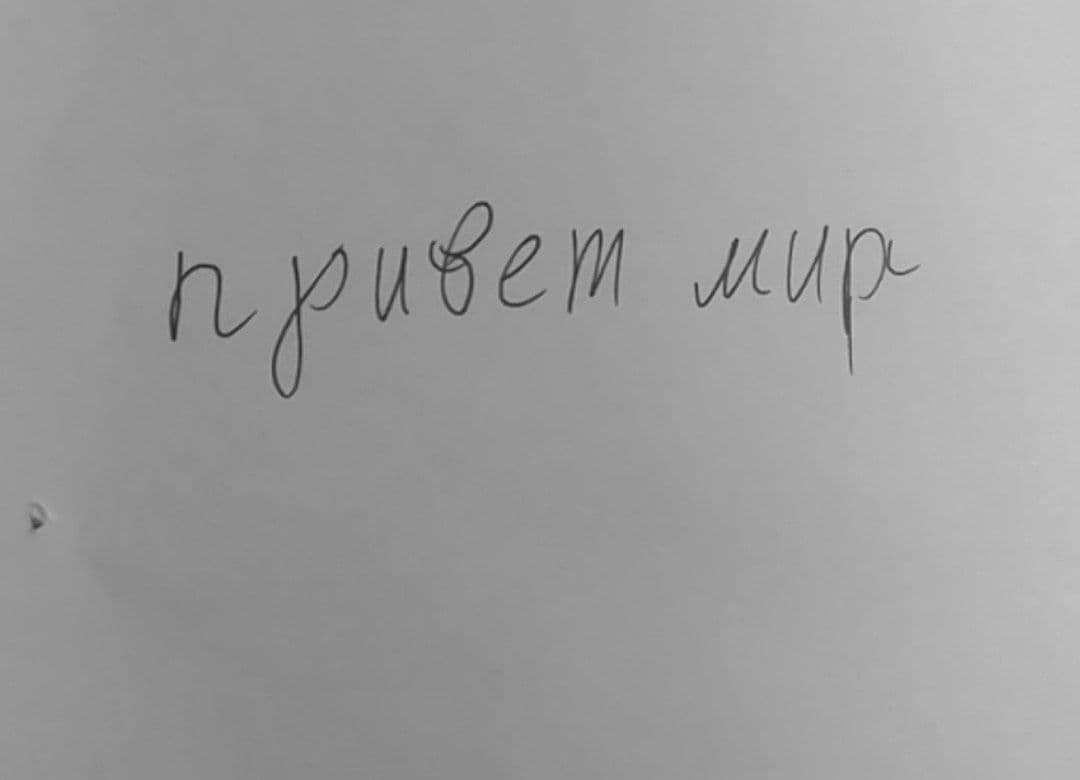

In [38]:
cv2_imshow(img)

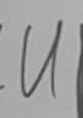

(118, 83)

In [39]:
cv2_imshow(img[coords['y']-20:coords['y']+coords['h']+20,coords['x']-20:coords['x']+coords['w']+20])
let = np.array(img[coords['y']-20:coords['y']+coords['h']+20,coords['x']-20:coords['x']+coords['w']+20])
let.shape

In [40]:
let = (let-127.5)/127.5

In [41]:
def letterPrepare(im,size):
  if im.shape[0] < im.shape[1]:
    im = np.append(im,np.ones((im.shape[1]-im.shape[0],im.shape[1])),0)
  '''elif im.shape[1] < im.shape[0]:
    for i in range(len(im)):
      im[i] = np.append(im[i],np.ones(im.shape[0]-im.shape[1]))
  '''
  im = cv2.resize(im,size)

  return im


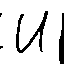

In [42]:
def normalizeImage(img):
  mean = np.mean(img)
  shape = img.shape
  img = np.reshape(img,(img.size))

  f = lambda num: ((int(num >= mean-0.2)-1)*2) + 1

  img = np.array(list(map(f,img)))

  img = img.reshape(shape)

  return img


test = letterPrepare(let,(64,64))




cv2_imshow(normalizeImage(test)*255)

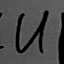

(64, 64, 1)

In [43]:
cv2_imshow(letterPrepare(let,(64,64))*255)
let = letterPrepare(let,(64,64))
let = normalizeImage(let)
let = np.expand_dims(let, -1)
let.shape

In [44]:
let.shape

(64, 64, 1)

In [45]:
pos = np.argmax(model.predict(np.array([let])))
dic[str(pos)]

'и'

Преобразование слова в массив картинок и предсказание по каждой букве



In [46]:
def heapify(nums, heap_size, root_index, coord):  
    largest = root_index
    left_child = (2 * root_index) + 1
    right_child = (2 * root_index) + 2

    if left_child < heap_size and nums[left_child][coord] > nums[largest][coord]:
        largest = left_child


    if right_child < heap_size and nums[right_child][coord] > nums[largest][coord]:
        largest = right_child


    if largest != root_index:
        nums[root_index], nums[largest] = nums[largest], nums[root_index]

        heapify(nums, heap_size, largest, coord)

def attributeSort(nums,coord):  
    n = len(nums)

    for i in range(n, -1, -1):
        heapify(nums, n, i, coord)

    for i in range(n - 1, 0, -1):
        nums[i], nums[0] = nums[0], nums[i]
        heapify(nums, i, 0, coord)
    
    return nums

In [47]:
test_coords = [{'x': 233,'y':255},{'x': 12,'y': 126},{'x': 5,'y':255}]  
attributeSort(test_coords,'x')  

[{'x': 5, 'y': 255}, {'x': 12, 'y': 126}, {'x': 233, 'y': 255}]

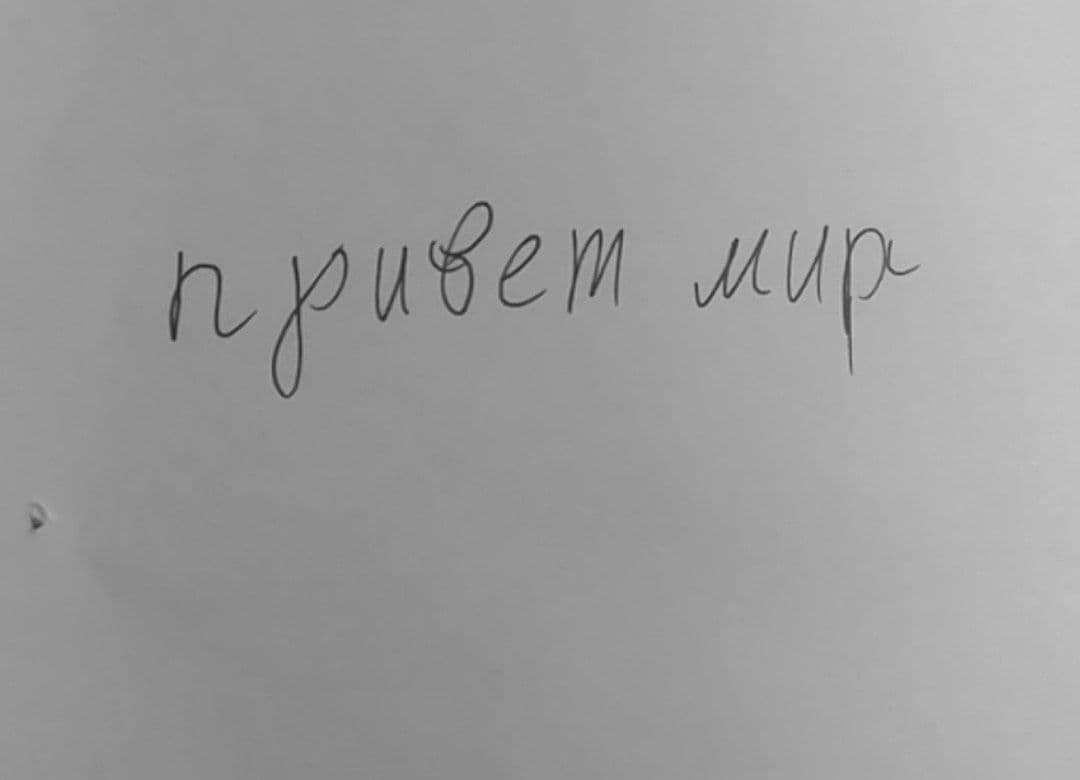

In [49]:
img = cv2.imread("/content/drive/MyDrive/ColabFiles/Text_Recognition/HelloWorld.jpg")
coords = get_LettersCoord(img,False)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

In [50]:
coords = attributeSort(coords,'x')
coords

[{'h': 93, 'w': 90, 'x': 168, 'y': 250},
 {'h': 157, 'w': 78, 'x': 271, 'y': 243},
 {'h': 79, 'w': 36, 'x': 374, 'y': 244},
 {'h': 117, 'w': 67, 'x': 427, 'y': 200},
 {'h': 76, 'w': 49, 'x': 498, 'y': 233},
 {'h': 87, 'w': 58, 'x': 566, 'y': 228},
 {'h': 80, 'w': 78, 'x': 693, 'y': 228},
 {'h': 78, 'w': 43, 'x': 786, 'y': 225},
 {'h': 146, 'w': 76, 'x': 842, 'y': 227}]

In [52]:
arrDistance = []
for i in range(len(coords)-1):
  arrDistance.append(coords[i+1]['x'] - (coords[i]['x']+coords[i]['w']))
medianDistance = arrDistance[len(arrDistance) // 2]

spaces = []
for i in range(len(coords)-1):
  if (coords[i+1]['x'] - (coords[i]['x']+coords[i]['w']))/medianDistance > 1.7:
    spaces.append(i)

print(spaces)

[5]


In [53]:
result = []

for coord in coords:
  #cv2_imshow(img[coord['y']-20:coord['y']+coord['h']+20,coord['x']-20:coord['x']+coord['w']+20])
  let = np.array(img[coord['y']-20:coord['y']+coord['h']+20,coord['x']-20:coord['x']+coord['w']+20])
  let = (let-127.5)/127.5
  #cv2_imshow(letterPrepare(let,(64,64))*255)
  let = letterPrepare(let,(64,64))
  let = np.expand_dims(let,-1)
  pos = np.argmax(model.predict(np.array([let])))
  result.append(dic[str(pos)])

Сбор и обработка пробного слова


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ColabFiles/Text_Recognition/autocorrect.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
from autocorrect import Speller
import difflib
spell = Speller(lang='ru')

dictionary for this language not found, downloading...
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!


In [ ]:
attributeSort(spell.autocorrect_word('рсчка'),0)

[(3, 'рсука'),
 (8, 'рсика'),
 (9, 'рэчка'),
 (15, 'рочка'),
 (32, 'рска'),
 (50, 'рачка'),
 (169, 'рська'),
 (1156, 'ручка'),
 (3985, 'речка')]

In [ ]:
result

['П', 'р', 'и', 'в', 'й', 'т', 'М', 'и', 'р']

In [ ]:
sent = ''
for i in range(len(result)):
  sent += result[i]
  if i in spaces:
    sent += ' '
sent

'Привйт Мир'

In [ ]:
candidates = attributeSort(spell.autocorrect_word(sent.split()[0]),0)
candidates.reverse()
candidates

[(1949, 'Привет'),
 (1799, 'приват'),
 (1698, 'привет'),
 (275, 'Приват'),
 (210, 'Прийт'),
 (24, 'привит')]

In [ ]:
goodCandidates = []
for i in candidates:
  if len(i[1]) == len(sent.split()[0]):
    goodCandidates.append(i[1])
goodCandidates

['Привет', 'приват', 'привет', 'Приват', 'привит']

In [ ]:
def similarity(s1, s2): #Нахождение коэффициента схожести между двумя строками
  normalized1 = s1.lower()
  normalized2 = s2.lower()
  matcher = difflib.SequenceMatcher(None, normalized1, normalized2)
  return matcher.ratio()

In [ ]:
similarity('Паивфт','приват')

0.6666666666666666